# Práctica 4 - Bordes y Esquinas

## Preparación

Para correr este Jupyter Notebook es necesario tener instalado Octave y octave_kernel, el cual permite utilizar Octave en Jupyter. En Ubuntu se pueden instalar mediante:

```
sudo apt-get install octave
```

y

```
pip3 install octave_kernel
```


## 1. Contaminamos *lena* y *test* con ruido

In [1]:
lena = imread("img/lena256.png");
test = imread("img/test.png");

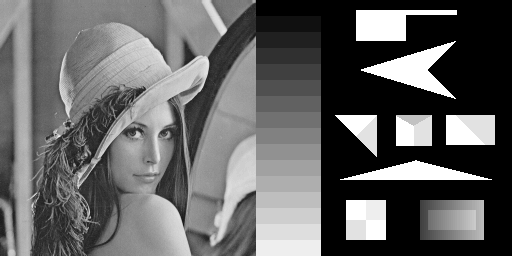

In [2]:
imshow([lena, test])

Definimos las funciones de ruido vistas en la práctica 3:

In [3]:
function res = gaussNoise(img, perc)
    Inoise = normrnd(0, 1, size(img));
    res = img + (Inoise * perc * 255);
endfunction

In [4]:
function res = rayleighNoise(img, epsilon)
    Inoise = sqrt(-epsilon * log(1 - rand(size(img))));
    res = img .* Inoise;
endfunction

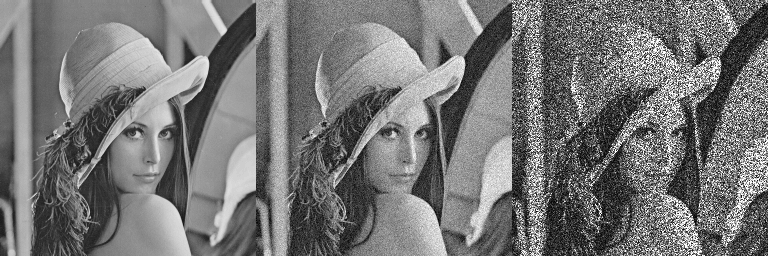

In [5]:
lenaGauss = gaussNoise(lena, 0.05);
lenaRayleigh = rayleighNoise(lena, 1);
imshow([lena, lenaGauss, lenaRayleigh])

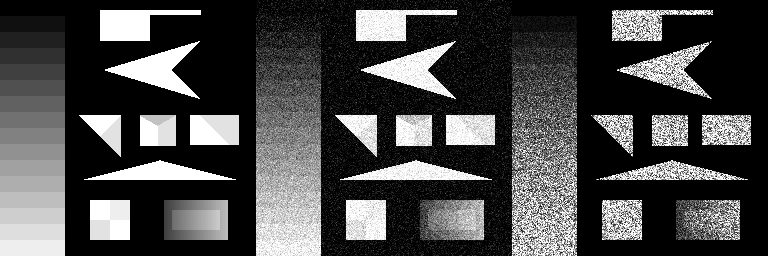

In [6]:
testGauss = gaussNoise(test, 0.1);
testRayleigh = rayleighNoise(test, 1);
imshow([test, testGauss, testRayleigh])

## 2. Detectores de borde

### a. Método del Laplaciano

In [7]:
laplaceKernel = [0 1 0; 1 -4 1; 0 1 0]

laplaceKernel =

   0   1   0
   1  -4   1
   0   1   0



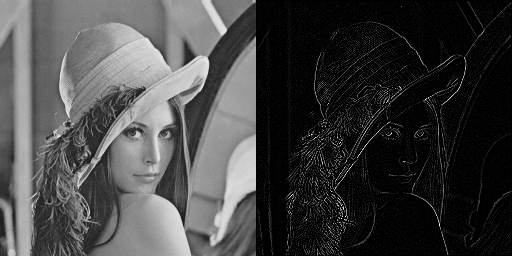

In [8]:
imshow([lena, conv2(lena, laplaceKernel, "same")])

#### Buscamos ahora los ceros en el filtro Laplaciano

In [9]:
filtIm = conv2(lena, laplaceKernel, "same");

El resultado de aplicar la convolución con el kernel Laplaciano es una aproximación a la suma de las derivadas de segundo orden en cada píxel de la imagen:

In [10]:
filtIm(1:10, 1:10)

ans =

  -325  -162  -154  -163  -169  -160  -159  -156  -149  -175
  -162    -4     6    -2    -6    -1    -3     0     7   -16
  -172    10    -2    -3    -7     5     3    -3     3   -12
  -165     4    -9    14    -5   -13    14    13    -8    14
  -142    -5     3    -2    -1     2    -5    -3     6   -10
  -154    -4    -6    30   -16     3     2     2    -7    12
  -161     3    -1    -7     0    -1    10   -17    11    -4
  -160    -5     4     0    -4    -1     5   -12     1    -1
  -155     2    -4    13    -3     3    -3    10    10     1
  -154     6   -13     5    -7     6    -2    -6    -6    -9



Lo que queremos buscar ahora son los cruces de ceros (zero-crossing), es decir, píxeles dónde el signo del laplaciano cambia en su vecindad.

In [11]:
function z = zerocrossings(f)
    zneg = f < 0;
    [R,C] = size(f);
    # z va a ser la matriz booleana de píxeles donde ocurre un cruce de ceros
    z = zeros(R,C);
    # Se marca 1 si un pixel vecino cambia de signo (comparando con zneg)
    z(1:R-1,:) |= zneg(2:R,:);
    z(2:R,:)   |= zneg(1:R-1,:);
    z(:,1:C-1) |= zneg(:,2:C);
    z(:,2:C)   |= zneg(:,1:C-1);
    # Finalmente se queda sólo con los cruces en los puntos no negativos (ceros y positivos)
    # para no contar borde doble (?)
    z &= !zneg;
endfunction

In [12]:
filtIm(1:5, 1:5), zerocrossings(filtIm)(1:5, 1:5)

ans =

  -325  -162  -154  -163  -169
  -162    -4     6    -2    -6
  -172    10    -2    -3    -7
  -165     4    -9    14    -5
  -142    -5     3    -2    -1

ans =

  0  0  0  0  0
  0  0  1  0  0
  0  1  0  0  0
  0  1  0  1  0
  0  0  1  0  0



#### Detector de bordes Laplaciano

Para detectar bordes con el filtro Laplaciano:
1. Convoluciona la imagen con el kernel Laplaciano, para obtener las derivadas parciales de segundo orden
2. Busca los cruces de ceros en la matriz Laplaciana
3. Aplica un umbral sobre los valores absolutos de la matriz, para quedarse con los píxeles de borde de "alto contraste", dado que el método es susceptible a ruido.

In [13]:
function res = edgeLaplace(img)
    f = [0 1 0; 1 -4 1; 0 1 0];
    # Aplica filtro Laplaciano
    g = conv2(img, f, "same");
    # Busca los cruces de ceros y aplica umbral
    thres = mean(abs(g));
    res = zerocrossings(g) & (abs(g) > thres);
endfunction

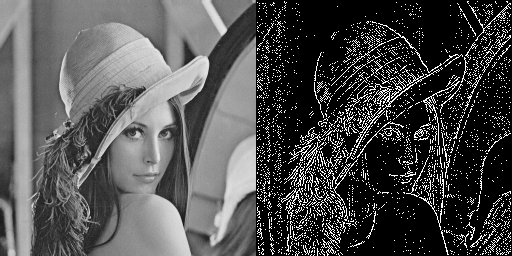

In [14]:
imshow([lena, edgeLaplace(lena)*255])

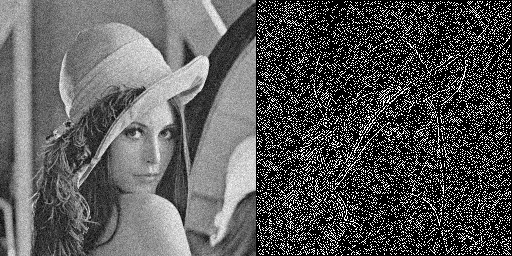

In [15]:
imshow([lenaGauss, edgeLaplace(lenaGauss)*255])

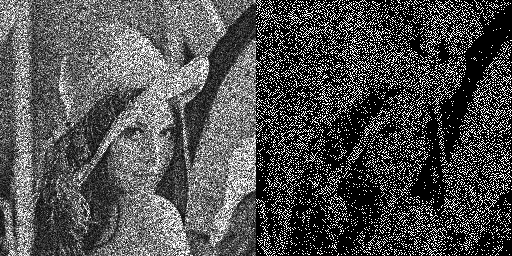

In [16]:
imshow([lenaRayleigh, edgeLaplace(lenaRayleigh)*255])

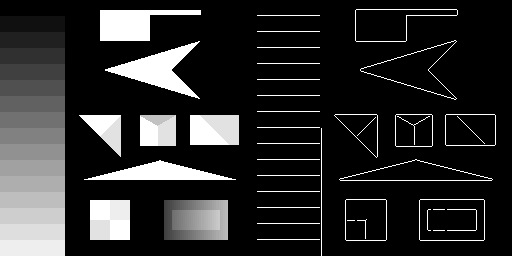

In [17]:
imshow([test, edgeLaplace(test)*255])

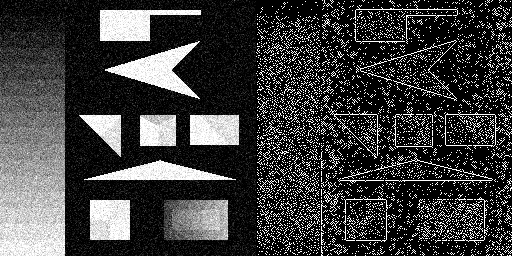

In [18]:
imshow([testGauss, edgeLaplace(testGauss)*255])

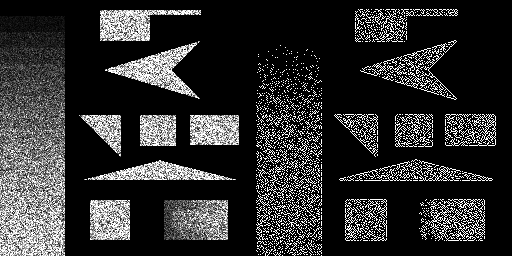

In [19]:
imshow([testRayleigh, edgeLaplace(testRayleigh)*255])

### c. Método del Laplaciano del Gaussiano

El método de detección de bordes es similar, pero aplicando un filtro gaussiano antes del Laplaciano...

In [20]:
function res = edgeLoG(img)
    # Aplica un filtro gaussiano 5x5
    f = [1,4,6,4,1; 4,16,24,16,4; 6,24,36,24,6; 4,16,24,16,4; 1,4,6,4,1]/256;
    g = conv2(img, f, "same");
    # Busca bordes con Laplace
    res = edgeLaplace(g);
endfunction

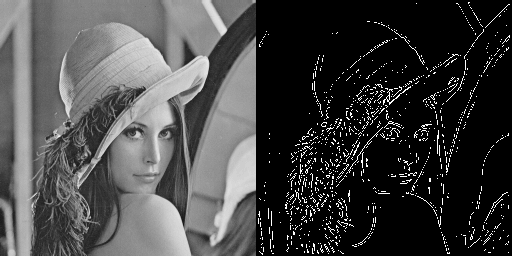

In [21]:
img = lena;
imshow([img, edgeLoG(img)*255])

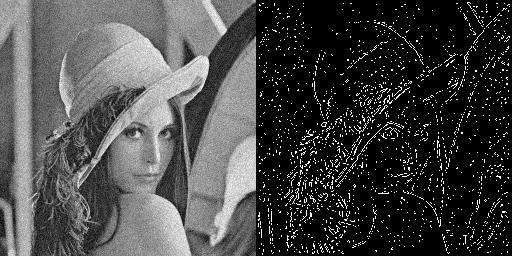

In [22]:
img = lenaGauss;
imshow([img, edgeLoG(img)*255])

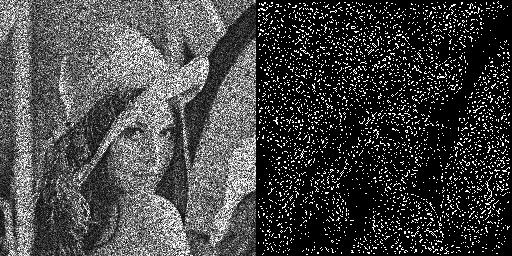

In [23]:
img = lenaRayleigh;
imshow([img, edgeLoG(img)*255])

## 3. Método de Canny

In [1]:
lena = imread("img/lena256.png");

### Obtención del gradiente y orientación

Primero aplicamos un filtro gaussiano para eliminar ruido. Generamos un kernel $5 \times 5$ con $\sigma=\sqrt 2$

In [2]:
% 5x5 gaussian kernel (sigma=sqrt(2)) generated with the "image" package:
%   pkg load image;
%   gauss = fspecial("gaussian", 5, sqrt(2))
gauss = [
   0.012478   0.026415   0.033918   0.026415   0.012478
   0.026415   0.055921   0.071804   0.055921   0.026415
   0.033918   0.071804   0.092198   0.071804   0.033918
   0.026415   0.055921   0.071804   0.055921   0.026415
   0.012478   0.026415   0.033918   0.026415   0.012478
]

gauss =

   0.012478   0.026415   0.033918   0.026415   0.012478
   0.026415   0.055921   0.071804   0.055921   0.026415
   0.033918   0.071804   0.092198   0.071804   0.033918
   0.026415   0.055921   0.071804   0.055921   0.026415
   0.012478   0.026415   0.033918   0.026415   0.012478



In [3]:
Igauss = conv2(lena, gauss, "same");

Calculamos las derivadas parciales con el filtro Roberts, y calculamos el gradiente y orientación a partir de ellas.

In [4]:
FilterRobertsX = [1 0 0; 0 -1 0; 0 0 0];
FilterRobertsY = [0 1 0; -1 0 0; 0 0 0];

In [5]:
Ix = conv2(Igauss, FilterRobertsX, "same");
Iy = conv2(Igauss, FilterRobertsY, "same");

In [6]:
Ig = sqrt(Ix .^ 2 + Iy .^ 2);
Io = atan2(Ix ,Iy);

### Supresión de no máximos

In [7]:
function res = nonmax_suppresion(Ig, Io)
    res = zeros(size(Ig));
    [filas, columnas] = size(Ig);
   
    for i = 2 : filas-1
        for j = 2 : columnas-1
            anguloEnDeg = Io(i,j) * 180/pi;
            if (anguloEnDeg < 45 && anguloEnDeg > -45)
                if Ig(i,j) > max(Ig(i-1,j), Ig(i+1,j))
                    res(i,j)=Ig(i,j);
                end
            end
            if (anguloEnDeg > 45 && anguloEnDeg < 135)
                if Ig(i,j) > max(Ig(i+1,j-1), Ig(i-1,j+1))
                    res(i,j)=Ig(i,j);
                end
            end
            if (anguloEnDeg > 135 || anguloEnDeg < -135)
                if Ig(i,j) > max(Ig(i,j-1), Ig(i,j+1))
                    res(i,j)=Ig(i,j);
                end
            end
            if (anguloEnDeg > -135 && anguloEnDeg < -45)
                if Ig(i,j) > max(Ig(i-1,j-1),Ig(i+1,j+1))
                    res(i,j)=Ig(i,j);
                end
            end
        end
    end
endfunction

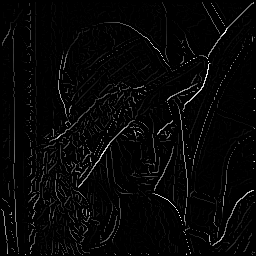

In [8]:
Inmax = nonmax_suppresion(Ig, Io);
imshow(Inmax)

### Histéresis de Umbral

Para la última etapa del detector de bordes de Canny, se implementa una umbralización por histéresis para eliminar ruido en el resultado de supresión de no máximos. Lamentablemente la implementación que escribimos hace uso de una **pila** para guardar las coordenadas visitadas, y como Octave/Matlab no tiene esta estructura de datos, recurrimos a Python para este proceso.

El código de Python es el siguiente y se encuentra en el archivo `hyst.py`:

```python
#!/usr/bin/env python3
import numpy as np
from imageio import imread, imwrite
from scipy.io import loadmat, savemat

def hist_thresh(infile, outfile, orientation, low, high):
    Im = np.loadtxt(infile)
    Io = np.loadtxt(orientation)

    rows, cols = np.nonzero(Im > high)
    S = list(zip(rows, cols))

    out = np.zeros(Im.shape, dtype=np.uint8)

    while S:
        r, c = S.pop()
        if out[r, c] > 0:
            continue

        # Mark as border
        out[r, c] = 255

        # Convert angle in radians to degrees
        angle = Io[r, c] * 180 / np.pi;

        # Grow region if magnitude exceeds low threshold
        if angle < 45 and angle > -45:
            if Im[r-1, c] > low:
                S.append((r-1, c))
            if Im[r+1, c] > low:
                S.append((r+1, c))
        elif angle > 45 and angle < 135:
            if Im[r-1, c-1] > low:
                S.append((r-1, c-1))
            if Im[r+1, c+1] > low:
                S.append((r+1, c+1))
        elif angle > 135 and angle < -135:
            if Im[r, c-1] > low:
                S.append((r, c-1))
            if Im[r, c+1] > low:
                S.append((r, c+1))
        elif angle > -135 and angle > -45:
            if Im[r-1, c+1] > low:
                S.append((r-1, c+1))
            if Im[r+1, c-1] > low:
                S.append((r+1, c-1))

    imwrite(outfile, out)

if __name__ == '__main__':
    import argparse

    parser = argparse.ArgumentParser(
            description='Apply hysteresis thresholding on image',
            formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    parser.add_argument('input',
            help='path to input image file')
    parser.add_argument('output',
            help='path to output image file')

    parser.add_argument('orientation',
            help='path to image of gradient orientation')
    parser.add_argument('low', type=int, help='low threshold')
    parser.add_argument('high', type=int, help='high threshold')

    args = parser.parse_args()

    hist_thresh(args.input, args.output, args.orientation, args.low, args.high)


```

Definimos una función en Octave para ejecutar este script dada una imagen de magnitud del gradiente (el resultado de supresión de no máximos), la imagen de orientación del gradiente, y las variables `low` y `high` que determinan los umbrales bajos y altos respectivamente. Para interactuar con Python, escribimos las matrices en archivos y hacemos que el script de python lea las matrices y escriba otra con la salida del algoritmo. Luego leemos nuevamente la salida para retornar la matriz resultado.

In [25]:
function res = hyst_thresh(Im, Io, low, high)
    outfile = "/tmp/out.png";
    infile = "/tmp/in.txt";
    orientation = "/tmp/orient.txt";
    
    save(infile, 'Im', '-ascii')
    save(orientation, 'Io', '-ascii')
    
    cmd = ["python3 hyst.py " infile " " outfile " " orientation " " num2str(low) " " num2str(high)]
    system(cmd);
    
    res = imread(outfile);
endfunction

Por ejemplo, aplicando el resultado del paso anterior con umbrales 5 y 15 da el siguiente resultado:

cmd = python3 hyst.py /tmp/in.txt /tmp/out.png /tmp/orient.txt 5 15


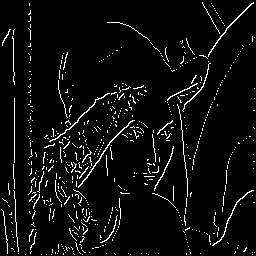

In [24]:
res = hyst_thresh(Inmax, Io, 5, 15);
imshow(res)